## IMPORTS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from metrics.overallscore import calculate_overall_score
from metrics.dataquality import calculate_data_quality_metrics
from metrics.dataquality import calculate_phone_number_metrics
from metrics.dataquality import calculate_email_metrics
from metrics.dataquality import calculate_average_metrics
from metrics.overallscore import calculate_overall_score_mom
from metrics.datacollectorscore import calculate_quality_score_by_collector

## READING DATA

In [2]:
data = pd.read_csv("data/aedc/customers.csv")

In [3]:
column_mapping = {
    'slrn': 'SLRN',
    'ac_no': 'Account Number',
    'meter_number': 'Meter Number',
    'meter_status': 'Meter Status',
    'phone_number': 'Phone Number',
    'email': 'Email',
    'date': 'Date',
    'first_captured_username': 'First Captured Username',
    'updated_username': 'Updated Username'
}
data_x = data.copy()
data_x.rename(columns=column_mapping, inplace=True)

In [4]:
df = data_x

## METRICS

In [9]:
# List to store metrics for each key field
metrics_list = []

# Calculate metrics for each key field
key_fields = ['SLRN', 'Account Number', 'Meter Number', 'Phone Number', 'Email']

for field_name in key_fields:
    if field_name in df.columns:
        if field_name in ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN']:
            metrics = calculate_data_quality_metrics(df, field_name, 'AEDCBD', 13)
        elif field_name == 'Phone Number':
            metrics = calculate_phone_number_metrics(df, field_name, 'AEDCBD', corresponding_meter_field='Meter Number')
        elif field_name == 'Email':
            metrics = calculate_email_metrics(df, field_name, corresponding_meter_field='Meter Number')
        
        metrics_list.append(metrics)

# Calculate average completeness, validity, and integrity
average_completeness = calculate_average_metrics(metrics_list, 'Completeness')
average_validity = calculate_average_metrics(metrics_list, 'Validity')
average_integrity = calculate_average_metrics(metrics_list, 'Integrity')

# Calculate overall score using the overall_score function
overall_score = calculate_overall_score(average_completeness, average_validity, average_integrity)

total_caims_data = data_x['Meter Number'].nunique()
print(f'\nSample Data: {total_caims_data:,}')

# Display the results
print("\nQuality Metrics for Each Field:")
for field_name in key_fields:
    if field_name in df.columns:
        print(f"\nMetrics for {field_name}:")
        print(f"Completeness: {metrics_list[key_fields.index(field_name)]['Completeness']:.2f}%")
        print(f"Validity: {metrics_list[key_fields.index(field_name)]['Validity']:.2f}%")
        print(f"Integrity: {metrics_list[key_fields.index(field_name)]['Integrity']:.2f}%")
        
        # Calculate and print the overall score for each field
        field_overall_score = calculate_overall_score(
            metrics_list[key_fields.index(field_name)]['Completeness'],
            metrics_list[key_fields.index(field_name)]['Validity'],
            metrics_list[key_fields.index(field_name)]['Integrity']
        )
        print(f"Overall Score: {field_overall_score:.2f}")

print("\nQuality Metrics - Average and Overall Score:")
print(f"Average Completeness: {average_completeness:.2f}%")
print(f"Average Validity: {average_validity:.2f}%")
print(f"Average Integrity: {average_integrity:.2f}%")
print(f"Overall Score: {overall_score:.2f}")



Sample Data: 39,233

Quality Metrics for Each Field:

Metrics for SLRN:
Completeness: 100.00%
Validity: 99.99%
Integrity: 100.00%
Overall Score: 100.00

Metrics for Account Number:
Completeness: 100.00%
Validity: 99.80%
Integrity: 100.00%
Overall Score: 100.00

Metrics for Meter Number:
Completeness: 95.57%
Validity: 95.11%
Integrity: 99.41%
Overall Score: 96.80

Metrics for Phone Number:
Completeness: 95.95%
Validity: 80.02%
Integrity: 66.46%
Overall Score: 83.60

Metrics for Email:
Completeness: 81.36%
Validity: 27.33%
Integrity: 0.31%
Overall Score: 44.00

Quality Metrics - Average and Overall Score:
Average Completeness: 94.57%
Average Validity: 80.45%
Average Integrity: 73.24%
Overall Score: 84.40


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year Month'] = df['Date'].dt.to_period('M')
df['date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
df["date"] = df.date.astype(str)
df["year_month"] = df.date.str[0:7]
df["year_month"] = df.year_month.str.replace('-', '')
df["year_month"] = df.year_month.apply(lambda x: int(x) if str(x).isdigit() else 0)

In [7]:
def calculate_unique_meter_count(df, date_column, meter_number_column):
    unique_meter_count = df.groupby(date_column)[meter_number_column].nunique().reset_index()
    unique_meter_count.columns = [date_column, 'Unique Meter Count']
    return unique_meter_count

# Compute unique meter count
unique_meter_count_df = calculate_unique_meter_count(df, 'Year Month', 'Meter Number')


# Calculate overall data quality score on a monthly basis and link it back to the DataFrame
mom_overall_score = calculate_overall_score_mom(df)
mom_overall_score_fil = mom_overall_score[mom_overall_score['year_month'] >= 202301]
mom_overall_score_fil = mom_overall_score_fil[['Year Month', 'Overall Score', 'year_month']]
mom_overall_score_fil = mom_overall_score_fil.sort_values(by='year_month', ascending=True)
mom_overall_score_fil = mom_overall_score_fil.drop_duplicates(subset=['Year Month'])

mom_overall_score_fil = pd.merge(mom_overall_score_fil, unique_meter_count_df, on='Year Month', how='left')

## MOM CHART

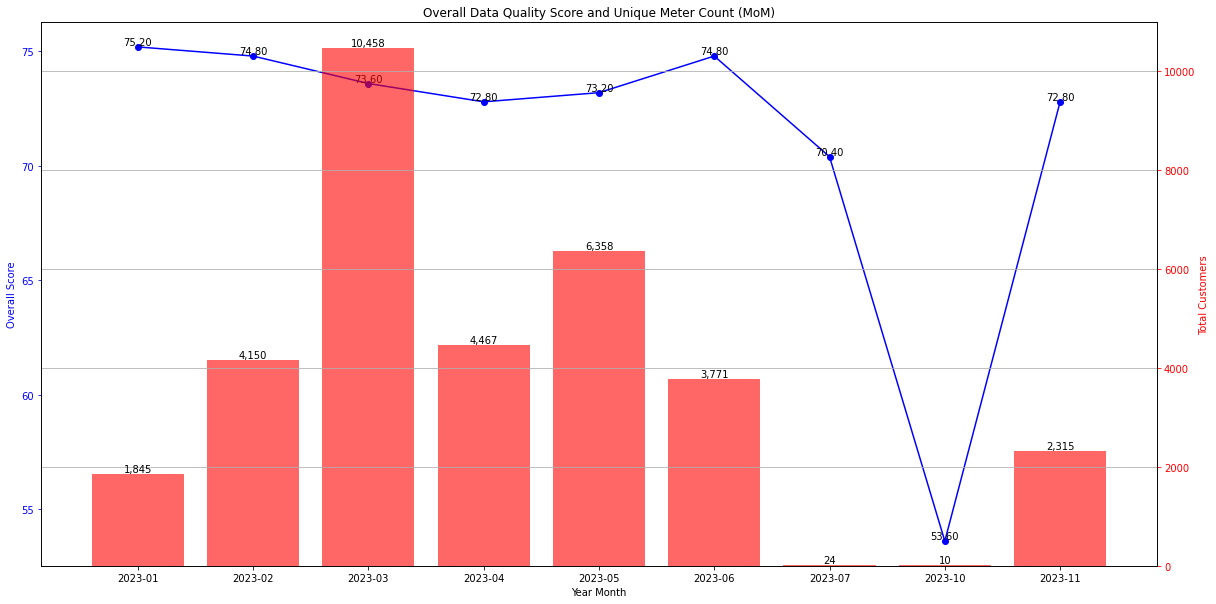

In [8]:
# Plot overall data quality score on a MoM basis
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot the overall score on the primary y-axis
ax1.plot(mom_overall_score_fil['Year Month'].astype(str), mom_overall_score_fil['Overall Score'].round(2), marker='o', linestyle='-', color='b', label='Overall Score')
ax1.set_xlabel('Year Month')
ax1.set_ylabel('Overall Score', color='b')
ax1.tick_params('y', colors='b')

# Add text annotations
for i, txt in enumerate(mom_overall_score_fil['Overall Score'].round(2)):
    ax1.text(mom_overall_score_fil['Year Month'].astype(str).iloc[i], txt, f'{txt:.2f}', ha='center', va='bottom')

# Create a secondary y-axis for the count of unique meter numbers
ax2 = ax1.twinx()
bars = ax2.bar(mom_overall_score_fil['Year Month'].astype(str), mom_overall_score_fil['Unique Meter Count'], alpha=0.6, color='red', label='Unique Meter Count')
ax2.set_ylabel('Total Customers', color='r')
ax2.tick_params('y', colors='r')

# Add labels on the bar chart with MoM figures
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', va='bottom', ha='center')

# Show the plot
plt.title('Overall Data Quality Score and Unique Meter Count (MoM)')
plt.grid(True)
plt.show()


In [15]:
mom_overall_score_fil[['Year Month', 'Overall Score']].to_csv('mom_overall_score_.csv', index=False)

## QUALITY SCORE BY DATA COLLECTOR

In [10]:
df_x = df[df['year_month'] >= 202311]

field_metrics = ['SLRN', 'Account Number', 'Meter Number', 'Phone Number', 'Email']

collector_scores = calculate_quality_score_by_collector(df_x, field_metrics)

collector_scores


,Average Completeness,Average Validity,Average Integrity,Overall Average
ComfortOf,40.00%,25.81%,27.69%,31.17%
DanladiB,40.00%,25.47%,26.00%,30.49%
VictoriaO,40.00%,25.39%,25.60%,30.33%
GodwinE,40.00%,25.30%,25.14%,30.15%
ChukwebukeIke,40.00%,25.16%,24.44%,29.87%
...,...,...,...,...
Idaluisrael,32.00%,20.62%,24.00%,25.54%
MajestyO,32.00%,17.07%,24.00%,24.36%
JUSTINADE,32.00%,17.07%,24.00%,24.36%
Daniel.omenka,24.00%,16.00%,24.00%,21.33%
